#Install Large Files

Connect your Google Drive first! Press button on left side.

In [1]:
# Root directory of the project
# ROOT_DIR = '/content/drive/My Drive/lego-cnn-master'
ROOT_DIR = './'

In [2]:
# !pip install gdown
# import gdown

# # Get example model weight
# url = 'https://drive.google.com/uc?id=1XjDlMButvwsZsYauUGybhY5aCBA1tBjo'
# output = ROOT_DIR + '/snapshots/lego20200717T1532/mask_rcnn_lego_0041.h5'
# gdown.download(url, output, quiet=False)

# # Get dataset 6
# url = 'https://drive.google.com/uc?id=1v4gsJ-2B3LQYKul6XNMrYCbZfIW0M1Wb'
# output = ROOT_DIR + '/datasets/images6.zip'
# gdown.download(url, output, quiet=False)

# # Get dateset 22
# url = 'https://drive.google.com/uc?id=1ZmavdrcbDyLNiySJlFPSSpz5vABg1vod'
# output = ROOT_DIR + '/datasets/images22.zip'
# gdown.download(url, output, quiet=False)

In [3]:
# # Unzip the dataset that you want
# unzip_dir = ROOT_DIR.replace(" ","\ ")

# !unzip -q $unzip_dir/datasets/images22.zip -d $unzip_dir/datasets
# !mv $unzip_dir/datasets/images22/* $unzip_dir/datasets/lego/

# !unzip -q $unzip_dir/datasets/images6.zip -d $unzip_dir/datasets
# !mv $unzip_dir/datasets/images6/* $unzip_dir/datasets/lego/

# Install Packages

In [4]:
import tensorflow as tf

tf.__version__

'2.6.0'

In [5]:
import os
import sys

# Prepare colab environment and load images
# os.system('pip install keras==2.2.4') # Must be 2.2.4 (or 2.3.0) otherwise get metrics_tensors error
# os.system('python setup.py build_ext --inplace; pip install .')
os.chdir(ROOT_DIR)

# Import Packages

In [6]:
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.lego import lego

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Infer RPN

### Load Configuration

In [7]:
# LEGO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "snapshots", "lego20200717T1532","mask_rcnn_lego_0041.h5") # Comment out to use snapshot from latest training
# LEGO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "snapshots", "lego20210912T0137","mask_rcnn_lego_0040.h5") # Comment out to use snapshot from latest training
LEGO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "snapshots", "lego20210912T1007","mask_rcnn_lego_0040.h5") # Comment out to use snapshot from latest training

DATASET = "eval"
config = lego.LegoConfig()
LEGO_DIR = os.path.join(ROOT_DIR, "datasets", "lego")

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


config = InferenceConfig()
config.display()

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


Configurations:
BACKBONE                       resnet101
BACKBONE_FITLERS_CONFIG        {'S2': [64, 64], 'S3': [128, 128], 'S4': [256, 256], 'S5': [512, 512]}
BACKBONE_MRCNN                 resnet18
BACKBONE_RESNET_BASIC_DEFAULT  {'S2': [64, 64], 'S3': [128, 128], 'S4': [256, 256], 'S5': [512, 512]}
BACKBONE_RESNET_BASIC_WIDER    {'S2': [160, 160], 'S3': [320, 320], 'S4': [640, 640], 'S5': [1280, 1280]}
BACKBONE_RESNET_BOTTLE_DEFAULT {'S2': [64, 64, 256], 'S3': [128, 128, 512], 'S4': [256, 256, 1024], 'S5': [512, 512, 2048]}
BACKBONE_RESNET_BOTTLE_WIDER   {'S2': [256, 256, 256], 'S3': [512, 512, 512], 'S4': [1024, 1024, 1024], 'S5': [1024, 1024, 2048]}
BACKBONE_RPN                   resnet18
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZ

### Load Dataset

In [8]:
dataset = lego.LegoDataset()
dataset.load_lego(LEGO_DIR, DATASET)
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 4
Classes: ['BG', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']


### Load Model and Weights

In [9]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
print("Loading weights ", LEGO_WEIGHTS_PATH)
model.load_weights(LEGO_WEIGHTS_PATH, by_name=True)

Instructions for updating:
Use fn_output_signature instead


2021-09-12 17:41:29.105366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-12 17:41:29.115790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-12 17:41:29.116365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Loading weights  ./snapshots/lego20210912T1007/mask_rcnn_lego_0040.h5


2021-09-12 17:41:30.238508: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-12 17:41:30.239188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-12 17:41:30.239887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-12 17:41:30.240503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Re-starting from epoch 40


### RPN Analysis

In [10]:
#if DATASET == "eval":
if DATASET != "eval":
    image_id = dataset.get_image_id("0000000002.png") # If eval set us the image with the Lego haufen
else:
    image_ids = np.random.choice(dataset.image_ids, 1)
    image_id = image_ids[0]
    
image, image_meta, gt_class_ids, gt_bboxes, gt_masks = modellib.load_image_gt(dataset, config, image_id)#, use_mini_mask=False)

In [11]:
# Run RPN sub-graph
if config.USE_RPN_ROIS:
    pillar = model.keras_model.get_layer("ROI").output

    # TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
    if nms_node is None:
        nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
    if nms_node is None: #TF 1.9-1.10
        nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

    rpn = model.run_graph([image], [
        ("rpn_class", model.keras_model.get_layer("rpn_class").output),         # Last layer in RPN with the proposed class probabilites for background or foreground per anchor
        ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
        ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
        ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
        ("post_nms_anchor_ix", nms_node),                                       # Filtered anchors that have a NMS of RPN_NMS_THRESHOLD (>0.7)
        ("proposals", model.keras_model.get_layer("ROI").output),               # "ROI" is the name of the ProposalLayers, the filtered rois proposals
    ])
#     ], config)

2021-09-12 17:41:52.359213: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-12 17:41:52.359757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-12 17:41:52.360193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-12 17:41:52.360638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-12 17:41:52.361037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

rpn_class                shape: (1, 172887, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.04813  max:    1.04332  float32
refined_anchors          shape: (1, 6000, 4)          min:  -13.56676  max:   13.19381  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1000.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


Best proposals are:

Proposal Bbox 0: 	[0 0 832 187] w=832 h=187 iou=0.02
Proposal Bbox 1: 	[0 0 0 0] w=0 h=0 iou=0.00
Proposal Bbox 2: 	[0 0 832 187] w=832 h=187 iou=0.00
Proposal Bbox 3: 	[0 0 832 187] w=832 h=187 iou=0.01
Proposal Bbox 4: 	[0 0 0 0] w=0 h=0 iou=0.00
Proposal Bbox 5: 	[0 0 0 0] w=0 h=0 iou=0.00
Proposal Bbox 6: 	[0 0 0 0] w=0 h=0 iou=0.00
Proposal Bbox 7: 	[0 0 0 0] w=0 h=0 iou=0.00
Proposal Bbox 8: 	[0 0 0 0] w=0 h=0 iou=0.00
Proposal Bbox 9: 	[0 0 0 0] w=0 h=0 iou=0.00
Proposal Bbox 10: 	[0 0 0 0] w=0 h=0 iou=0.00

Average maximum IoU is: 0.00


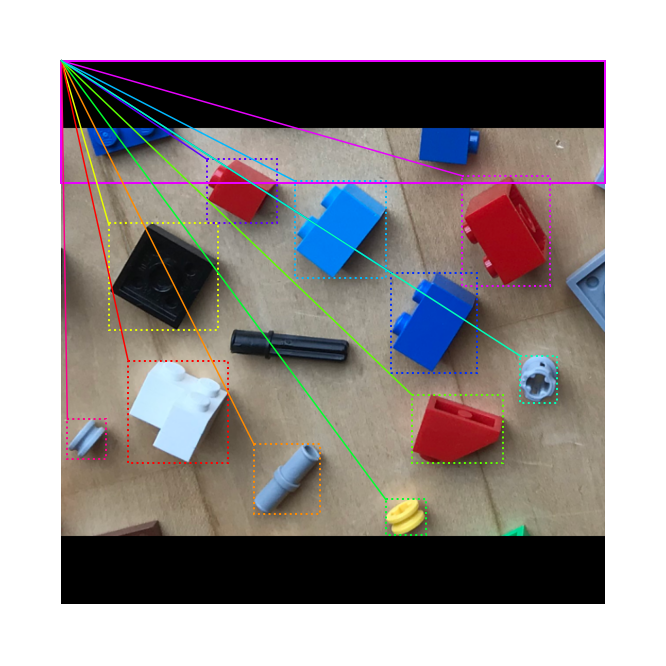

In [12]:
# Find the proposal that has the highest IoU on each GT box and take average of all
max_proposals_bbox = np.empty((gt_bboxes.shape[0], 4))
max_proposals_iou = np.empty((gt_bboxes.shape[0], 1))

# Get proposals from graph
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :] * np.array([h, w, h, w])

print("Best proposals are:\n")
for i, box in enumerate(gt_bboxes):

    overlaps = utils.compute_overlaps(np.array([box.tolist()]), proposals)
    iou_max = np.max(overlaps, axis=1)
    iou_argmax = np.argmax(overlaps, axis=1)
    max_proposals_bbox[i] = proposals[iou_argmax]
    max_proposals_iou[i] = iou_max

    y1, x1, y2, x2 = proposals[iou_argmax][0]
    iou = iou_max[0]

    print("Proposal Bbox {}: \t[{:.0f} {:.0f} {:.0f} {:.0f}] w={:.0f} h={:.0f} iou={:.2f}".format(i, x1, y1, x2, y2, x2-x1, y2-y1, iou))


print("\nAverage maximum IoU is: {0:0.2f}".format(np.average(max_proposals_iou)))
visualize.draw_boxes(image, boxes=gt_bboxes, refined_boxes=max_proposals_bbox)

# Run Evaluation

/home/fandavid/.conda/envs/rcnn/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


mAP@0.5:  0.0


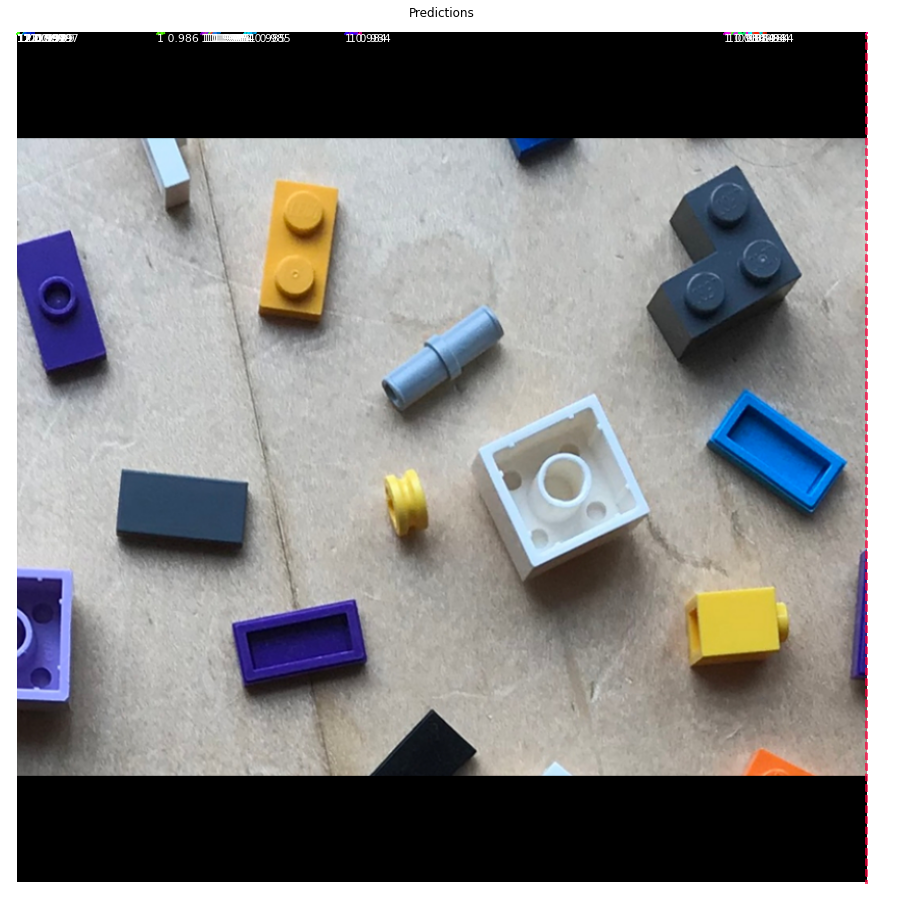

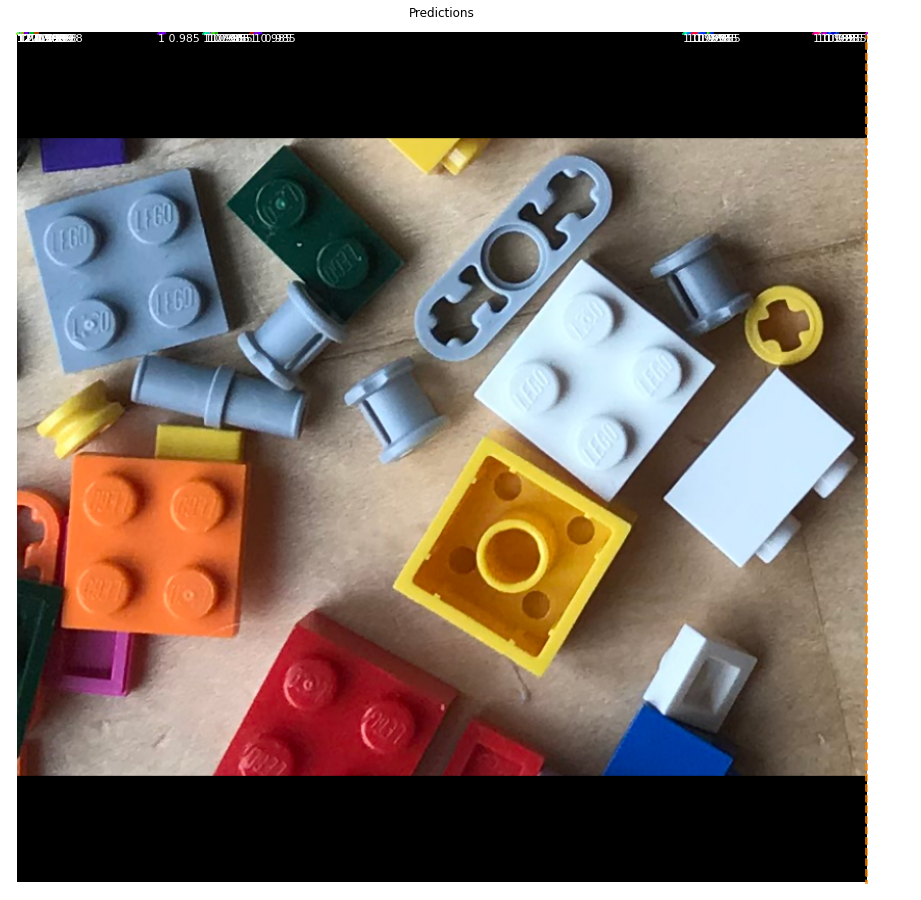

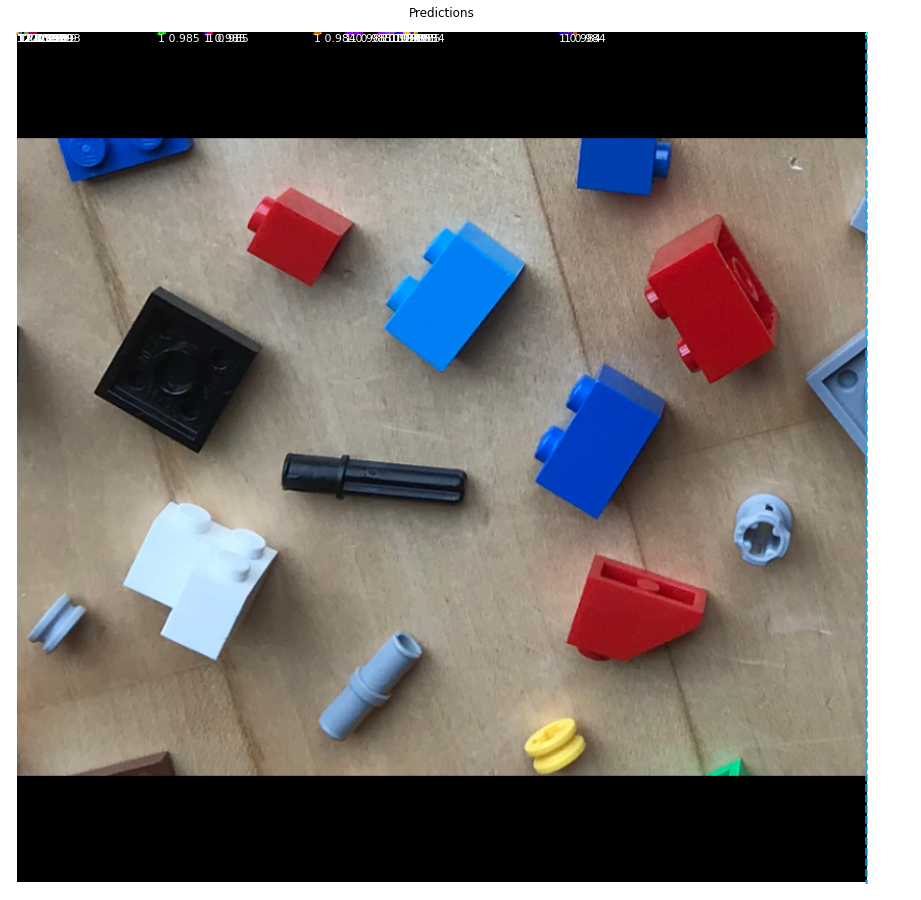

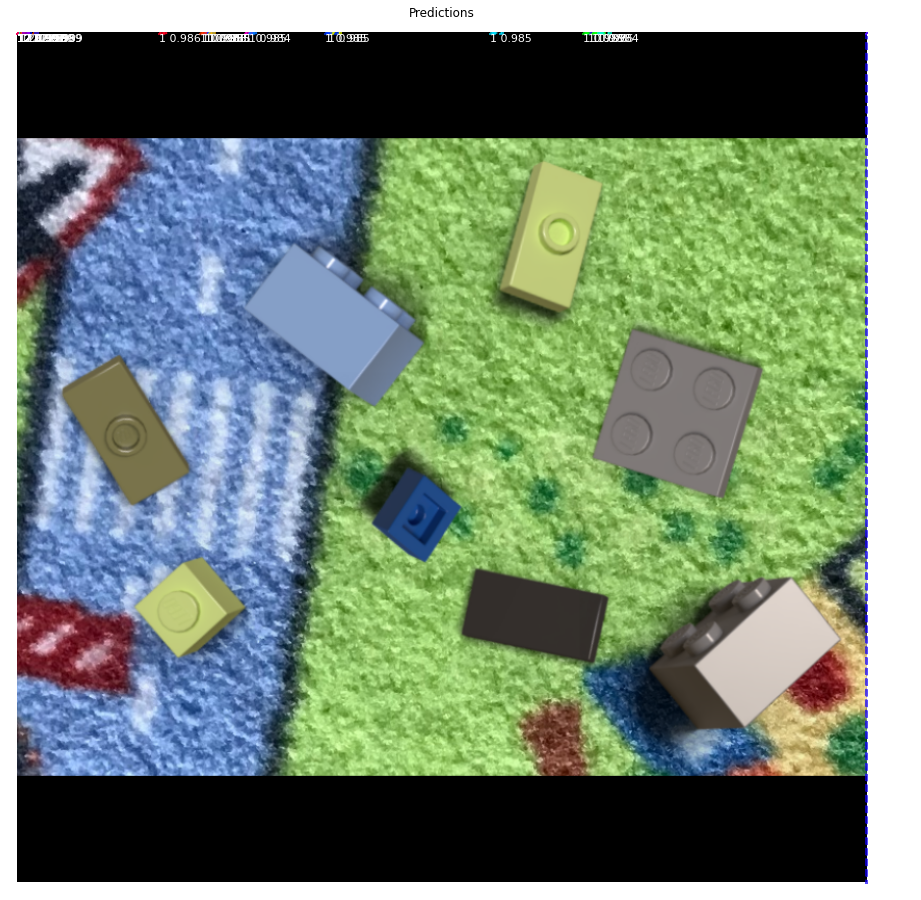

In [13]:
# Compute VOC-Style mAP @ IoU=0.5
APs = []
TPs = []
FPs = []
total_instances = 0

# IoU threshold to determine a postive match
mAP_IOU_THRESHOLD = 0.5

if DATASET == "eval":
    image_ids = dataset.image_ids
else:
    image_ids = np.random.choice(dataset.image_ids, 5 if config.USE_STAGE_TWO else 1)

for image_id in image_ids:

    # Load image and ground truth data
    image, image_meta, gt_class_ids, gt_bboxes, gt_masks =  modellib.load_image_gt(dataset, config, image_id)#, use_mini_mask=False)

    # Run object detection
#     results = model.detect([image], gt_class_ids, gt_bboxes, gt_masks, verbose=0)
    results = model.detect([image], verbose=0)
    r = results[0]

    ax = get_ax(1)
#     visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, gt_bboxes, gt_class_ids, 
#                                 r['scores'], ax=ax, title="Predictions")
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, 
                                r['scores'], ax=ax, title="Predictions")

    # Compute AP, IoU ist mit den Masken berechnet, nicht mit Bboxen
#     AP, precisions, recalls, overlaps, true_positives, false_positives = utils.compute_ap(  gt_bboxes, gt_class_ids, gt_masks,    
#                                                                                             r["rois"], r["class_ids"], r["scores"], r['masks'],
#                                                                                             iou_threshold=mAP_IOU_THRESHOLD)
    
    AP, precisions, recalls, overlaps = utils.compute_ap(  gt_bboxes, gt_class_ids, gt_masks,    
                                                           r["rois"], r["class_ids"], r["scores"], r['masks'],
                                                           iou_threshold=mAP_IOU_THRESHOLD)
#     if true_positives == 0 and false_positives == 0:
#         print("\n*** No instances matched in {} *** \n".format(dataset.image_info[image_id]["id"]))
        
    APs.append(AP)
#     TPs.append(true_positives)
#     FPs.append(false_positives)
    total_instances += len(gt_bboxes)

# tps = int(np.sum(TPs))
# fps = int(np.sum(FPs))

# print('TP: {:2.0f}   FP: {:2.0f}   TP/FP: {:2.1f}   TP/Total: {:2.0f}%'.format(tps, fps, 0 if fps == 0 else (tps/fps), 0 if total_instances == 0 else (100.0/total_instances)*tps))
print("mAP@" + str(mAP_IOU_THRESHOLD)+ ": ", np.mean(APs))


# Train CNN

In [3]:
import samples.lego.lego
import mrcnn.model
import mrcnn.utils
import mrcnn.config
import os, sys

# If you change code on the fly, reload modules
import imp
imp.reload(mrcnn.config)
imp.reload(samples.lego.lego)
imp.reload(mrcnn.model)
imp.reload(mrcnn.utils)

from samples.lego.lego import main as tmain

# Configuration section
PATH_DATASET                = os.path.join('datasets', 'lego')
USE_PREV_WEIGHTS            = False # Set to True if you want to restart from a previous session
NB_OF_EPOCHS                = 45 # Typically 40 epoches are sufficient for this project, 

# Where are we
print('Script running in: ' + os.getcwd())
print("Python version: " + sys.version)
print("Python install path: " + sys.executable)

# Show tool version
import tensorflow
print(tensorflow.__version__)
# import keras
# print(keras.__version__)


# Call train function
if USE_PREV_WEIGHTS:
    LEGO_WEIGHTS_PATH = tmain([ 'train', '--dataset=' + PATH_DATASET, '--logs=snapshots', '--enable-augmentation', '--weights=last','--epochs=' + str(NB_OF_EPOCHS)])
else:
    LEGO_WEIGHTS_PATH = tmain([ 'train', '--dataset=' + PATH_DATASET, '--logs=snapshots','--enable-augmentation', '--epochs=' + str(NB_OF_EPOCHS)])

Script running in: /home/panda/ldm/Lego-CNN
Python version: 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
Python install path: /home/panda/.conda/envs/lego/bin/python
2.5.0
Weights:  None
Dataset:  datasets/lego
Logs:  snapshots

Configurations:
BACKBONE                       resnet101
BACKBONE_FITLERS_CONFIG        {'S2': [64, 64], 'S3': [128, 128], 'S4': [256, 256], 'S5': [512, 512]}
BACKBONE_MRCNN                 resnet18
BACKBONE_RESNET_BASIC_DEFAULT  {'S2': [64, 64], 'S3': [128, 128], 'S4': [256, 256], 'S5': [512, 512]}
BACKBONE_RESNET_BASIC_WIDER    {'S2': [160, 160], 'S3': [320, 320], 'S4': [640, 640], 'S5': [1280, 1280]}
BACKBONE_RESNET_BOTTLE_DEFAULT {'S2': [64, 64, 256], 'S3': [128, 128, 512], 'S4': [256, 256, 1024], 'S5': [512, 512, 2048]}
BACKBONE_RESNET_BOTTLE_WIDER   {'S2': [256, 256, 256], 'S3': [512, 512, 512], 'S4': [1024, 1024, 1024], 'S5': [1024, 1024, 2048]}
BACKBONE_RPN                   resnet18
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE   

2021-09-19 15:59:39.783804: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-09-19 15:59:39.783861: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-09-19 15:59:39.783986: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1661] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-19 15:59:40.113442: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-09-19 15:59:40.113995: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1752] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-19 15:59:40.170482: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-19 15:59:40.199879: I tensorflow

1280/1280 [==============================] - 565s 427ms/step - batch: 639.5000 - size: 1.0000 - loss: 2.0161 - rpn_class_loss: 0.4334 - rpn_bbox_loss: 0.4276 - mrcnn_class_loss: 0.0975 - mrcnn_bbox_loss: 0.4916 - mrcnn_mask_loss: 0.5660 - val_loss: 1.2208 - val_rpn_class_loss: 0.2341 - val_rpn_bbox_loss: 0.2504 - val_mrcnn_class_loss: 0.0844 - val_mrcnn_bbox_loss: 0.2909 - val_mrcnn_mask_loss: 0.3608
Epoch 2/45
1280/1280 [==============================] - 479s 374ms/step - batch: 639.5000 - size: 1.0000 - loss: 1.0263 - rpn_class_loss: 0.1555 - rpn_bbox_loss: 0.2241 - mrcnn_class_loss: 0.1109 - mrcnn_bbox_loss: 0.2365 - mrcnn_mask_loss: 0.2993 - val_loss: 0.7581 - val_rpn_class_loss: 0.0644 - val_rpn_bbox_loss: 0.1775 - val_mrcnn_class_loss: 0.1096 - val_mrcnn_bbox_loss: 0.1695 - val_mrcnn_mask_loss: 0.2370
Epoch 3/45
1280/1280 [==============================] - 489s 382ms/step - batch: 639.5000 - size: 1.0000 - loss: 0.6831 - rpn_class_loss: 0.0541 - rpn_bbox_loss: 0.1582 - mrcnn_clas

KeyboardInterrupt: 